In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import json
import math

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
with open('config.json') as file:
    config = json.load(file)
    host = config['host']
    database = config['database']
    user = config['user']
    password = config['password']

In [3]:
engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{database}')

In [4]:
query = """
SELECT * FROM ms_encounters WHERE "EncType"='I'
"""

inpatient_encounters = pd.read_sql_query(query, engine)

In [6]:
query = """
select * from ms_vitals mv
where "Vital_Rel_Day" <= 0
"""

vitals_at_admission = pd.read_sql_query(query, engine)

In [7]:
vitals_at_admission.head()

,index,HospID,PtID,AdmtID,Vital_Rpt_Time,Vital_Id_Txt,Vital_Result_Value_Txt,Vital_UOM,Vital_Rel_Day,Source_System_Original_Code
0,0,27300,137027955,182539000150965479,10:15:00,Pulse:,80,?,0,K33010006A
1,1,27150,136343127,183519000143962458,07:11:00,Temperature C:,36.2,c,0,K33010002A
2,2,31608,136474146,190039000196985122,16:23:00,Height in:,10,in,0,K31010008A
3,3,27450,226147569,190059000147031728,20:22:00,Respiratory rate:,18,?,0,K33010016A
4,4,27100,138263915,190099000197924696,04:10:00,Temperature C:,37.1,c,0,K33010002A


In [8]:
vitals_at_admission['Vital_Id_Txt'].value_counts()

Pulse:                      213016
SPO2 %:                     195845
Blood pressure:             160103
Respiratory rate:           128732
Temperature C:               64706
Pulse source:                59714
Temperature source:          53802
Respiratory source:          43782
Weight kg:                   34078
Weight source:               33778
Height in:                   31428
Height ft:                   31367
Blood pressure source:       16478
Temperature F:               14106
Blood pressure location:      6820
Height cm:                    4461
Weight lb:                    1903
Weight oz:                     349
Head circumference cm:          77
K31010007A                       2
K31010003A                       2
K31010008A                       2
K31010005A                       2
K33010004A                       1
K33010016A                       1
K33010028A                       1
K33010006A                       1
L35010001A                       1
K33010003A          

In [9]:
def convert_to_datetime(row):
    return datetime.strptime('23:59:59', '%H:%M:%S') if row['Vital_Rpt_Time'] == '?' else datetime.strptime(row['Vital_Rpt_Time'], '%H:%M:%S')

vitals_at_admission['Vital_datetime'] = vitals_at_admission.apply(lambda row: convert_to_datetime(row), axis=1)

In [10]:
vitals_at_admission.sort_values(['Vital_Rel_Day', 'Vital_datetime'], inplace=True)

In [11]:
inpatient_admission_ids = inpatient_encounters['AdmtID']

In [12]:
vitals_for_inpatient_stays = vitals_at_admission[vitals_at_admission['AdmtID'].isin(inpatient_admission_ids)]

In [13]:
vitals_for_inpatient_stays.head()

,index,HospID,PtID,AdmtID,Vital_Rpt_Time,Vital_Id_Txt,Vital_Result_Value_Txt,Vital_UOM,Vital_Rel_Day,Source_System_Original_Code,Vital_datetime
670,671,27150,136315583,181939000195973658,13:13:00,Weight source:,Standing:Standing scale,?,-105,K31010005A,1900-01-01 13:13:00
1389,1391,27150,136315583,181939000195973658,13:13:00,Respiratory rate:,18,?,-105,K33010016A,1900-01-01 13:13:00
2107,2111,27150,136315583,181939000195973658,13:13:00,Blood pressure source:,NoninvsMon:Non-invasive monitor,?,-105,K33010028A,1900-01-01 13:13:00
2823,2831,27150,136315583,181939000195973658,13:13:00,Height ft:,5,ft,-105,K31010007A,1900-01-01 13:13:00
3539,3551,27150,136315583,181939000195973658,13:13:00,Pulse:,78,?,-105,K33010006A,1900-01-01 13:13:00


In [14]:
groupby_admissions = vitals_for_inpatient_stays.groupby('AdmtID')

In [156]:
vitals_dict = {}

for name, group in groupby_admissions:
    recent_respiratory_rate_series = group[group['Vital_Id_Txt'] == 'Blood pressure:'].tail(1)['Vital_Result_Value_Txt'].reset_index(drop=True)
    recent_respiratory_rate = math.nan if len(recent_respiratory_rate_series) == 0 else recent_respiratory_rate_series[0]
    temperature_c = group[group['Source_System_Original_Code'] == 'K33010002A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    temperature_f = group[group['Source_System_Original_Code'] == 'K33010003A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    temperature_f_to_c = temperature_f.apply(lambda f: (f - 32) * (5/9))
    temperature_c.append(temperature_f_to_c)
    
    weight_kg = group[group['Source_System_Original_Code'] == 'K31010003A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    weight_lb = group[group['Source_System_Original_Code'] == 'K31010001A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    weight_lb_to_kg = weight_lb.apply(lambda lb: lb / 2.205)
    weight_kg.append(weight_lb_to_kg)
    
    
    vitals_dict[name] = {
        "mean_pulse": get_mean_of_continuous_variable(group, 'K33010006A'),
        "mean_oxygen_levels": get_mean_of_continuous_variable(group, 'L35010001A'),
        "recent_respiratory_rate": recent_respiratory_rate,
        "mean_temperature_c": temperature_c.mean(),
        "mean_weight_kg": weight_kg.mean()
    }

In [157]:
aggregated_vitals = pd.DataFrame(vitals_dict).T.reset_index().rename(index=int, columns={'index': 'AdmtID'})
aggregated_vitals.head()

,AdmtID,mean_pulse,mean_oxygen_levels,recent_respiratory_rate,mean_temperature_c,mean_weight_kg
0,172480817323018509,68,96,119/67,36.4217,NaN
1,181550818221412364,110.333,96.6667,115/67,36.725,29.3
2,181799000166943661,84,93,134/76,36.5667,96.25
3,181799000203983706,61,94.6667,93/59,36.42,NaN
4,181799000215963959,NaN,NaN,NaN,36,NaN


In [120]:
def get_mean_of_continuous_variable(df, code, num_recent = 3):
    matched_code = df[df['Source_System_Original_Code'] == code]
    n_most_recent = matched_code.tail(num_recent)
    mean = n_most_recent['Vital_Result_Value_Txt'].astype(float).mean()
    return mean

In [150]:
vitals_at_admission[vitals_at_admission['Vital_Id_Txt'] == 'Weight lb:']

,index,HospID,PtID,AdmtID,Vital_Rpt_Time,Vital_Id_Txt,Vital_Result_Value_Txt,Vital_UOM,Vital_Rel_Day,Source_System_Original_Code,Vital_datetime
164417,335007,27300,137080162,190189000224934710,16:46:00,Weight lb:,130,lb,-38,K31010001A,1900-01-01 16:46:00
587129,1922538,27150,136185736,190589000196944562,11:36:00,Weight lb:,161,lb,-26,K31010001A,1900-01-01 11:36:00
787083,2832328,27300,137082827,190499000212972789,22:14:00,Weight lb:,181,lb,-22,K31010001A,1900-01-01 22:14:00
799575,2897362,27300,137091986,190109000148971714,06:46:00,Weight lb:,160,lb,-19,K31010001A,1900-01-01 06:46:00
713269,2479493,27400,137174031,190499000181953183,16:03:00,Weight lb:,190,lb,-19,K31010001A,1900-01-01 16:03:00
...,...,...,...,...,...,...,...,...,...,...,...
1071086,4807705,27300,137074198,183309000137960080,23:52:00,Weight lb:,217,lb,0,K31010001A,1900-01-01 23:52:00
1035700,4405960,27150,136229534,190109000169941862,23:54:00,Weight lb:,220,lb,0,K31010001A,1900-01-01 23:54:00
1059926,4662633,27300,137091269,190039000239982505,23:56:00,Weight lb:,171,lb,0,K31010001A,1900-01-01 23:56:00
899201,3463780,27150,136348662,190519000188934256,23:57:00,Weight lb:,175,lb,0,K31010001A,1900-01-01 23:57:00


In [138]:
aggregated_vitals['recent_respiratory_rate'][0].reset_index(drop=True)[0]

'119/67'

In [158]:
aggregated_vitals

,AdmtID,mean_pulse,mean_oxygen_levels,recent_respiratory_rate,mean_temperature_c,mean_weight_kg
0,172480817323018509,68,96,119/67,36.4217,NaN
1,181550818221412364,110.333,96.6667,115/67,36.725,29.3
2,181799000166943661,84,93,134/76,36.5667,96.25
3,181799000203983706,61,94.6667,93/59,36.42,NaN
4,181799000215963959,NaN,NaN,NaN,36,NaN
...,...,...,...,...,...,...
9718,193659000219922332,92,94.6667,95/56,36.6556,69.641
9719,193659000219954861,90.5,NaN,118/75,35.9,NaN
9720,193659000240927091,102.667,99,114/73,36.725,60.65
9721,193659000245930062,58.3333,95,100/61,36.3571,NaN


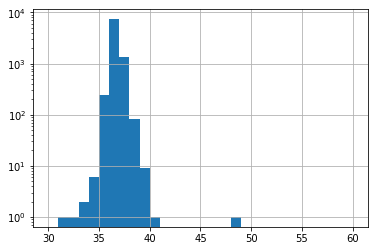

In [163]:
ax = aggregated_vitals['mean_temperature_c'].hist(range=(30,60), bins=30, log=True)

In [178]:
hist_params = {
    "range":(30,110),
    "bins": 60,
    "log": True,
    "alpha": 0.6
}

In [191]:
aggregated_vitals[col] = aggregated_vitals[col].fillna(-1)
df1 = aggregated_vitals[aggregated_vitals['AdmtID'] % 2 == 1]
df2 = aggregated_vitals[aggregated_vitals['AdmtID'] % 2 == 0]

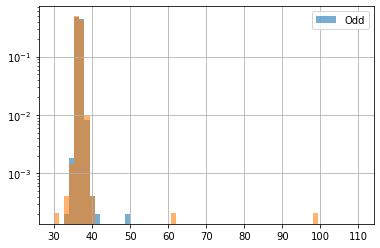

In [193]:
col = 'mean_temperature_c'

ax = df1[col].hist(**hist_params, label="Odd", weights=[1/len(df1[col])]*len(df1[col]))
df2[col].hist(**hist_params, ax=ax, weights=[1/len(df2[col])]*len(df2[col]))
ax.legend()


In [15]:
# Create a new column that enumerates the values from a categorical variable
# Use that as the base for the histogram
# Remap labels back to Strings

# For distance-based algos, think about setting nulls/nans as medians
# Else use something out of range

# Things to watch for
# Watch the plots
# Weird outliers
# Plot full range
# THEN plot the bulk of the distribution
# Double Peaks ? Makes sense or not?

# Procedures and drugs
# Drugs: Rank Drugs by the impact of LOS

In [21]:
query = """
select *
from ms_procedures mp 
where mp."Rel_Service_Day" <= 0
"""

procedures = pd.read_sql_query(query, engine)

In [22]:
procedures.head()

,index,HospID,PtID,AdmtID,Proc_Seq_Num,PX,PX_Desc,PX_CodeType,OrigPX,Rel_Service_Day
0,1,27150,136337448,190589000168951866,3,0QPB04Z,"Removal of Int Fix from R Low Femur, Open Appr...",0,0QPB04Z,0
1,3,27400,137137200,190369000260953497,3,0RG40J1,"Fusion C-thor Jt w Synth Sub, Post Appr P Col,...",0,0RG40J1,0
2,4,26330,135865564,190649000262960150,190314010714832552,0C1725,"Cath, translumin non-laser",5,0C1725,0
3,5,27200,137043365,193659000191913414,9,0DBP8ZX,"Excision of Rectum, Endo, Diagn",0,0DBP8ZX,0
4,7,27150,136315583,181939000195973658,190115001419553456,0C9290,"Inj, bupivacaine liposome",5,0C9290,0


In [23]:
procedures['PX_Desc'].value_counts()[:50]

Ondansetron hcl injection       17294
Inj, propofol, 10 mg            16728
Ringers lactate infusion        15327
COMPLETE CBC AUTOMATED          14054
Normal saline solution infus    11725
Compounded drug, noc            11599
Dexamethasone sodium phos       11137
Inj midazolam hydrochloride     10712
Cefazolin sodium injection      10690
Anchor/screw bn/bn,tis/bn        9469
TISSUE EXAM BY PATHOLOGIST       8284
METABOLIC PANEL TOTAL CA         7262
Joint device (implantable)       7041
ELECTROCARDIOGRAM TRACING        6696
Ketorolac tromethamine inj       6087
COMPREHEN METABOLIC PANEL        5652
BLOOD TYPING SEROLOGIC RH(D)     5432
BLOOD TYPING SEROLOGIC ABO       5430
RBC ANTIBODY SCREEN              5364
PROTHROMBIN TIME                 5332
Inj heparin sodium per 1000u     4507
Guide wire                       4472
Fentanyl citrate injection       4458
Neostigmine methylslfte inj      4419
EMERGENCY DEPT VISIT             4240
Hospital observation per hr      4142
Intro/sheath